In [1]:
import os
import datetime
import pandas as pd
import geopandas as gpd
import sklearn
import datetime
import logging
from logging.handlers import RotatingFileHandler
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

from util.isochrones import Isochrones
from util.gtfsdownloader import GtfsDownloader
from util.graphhopper import Graphhopper

# %load_ext autoreload
# %autoreload 2

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

from dotenv import load_dotenv
load_dotenv()

DROOT = './1-data'
drootf = lambda path: os.path.join(DROOT, path)

formatter = logging.Formatter('%(asctime)s: %(levelname)-8s %(message)s', datefmt='%Y%m%d,%H:%M:%S')
logging.getLogger().setLevel(logging.DEBUG)
file_handler = RotatingFileHandler(os.path.join(DROOT, 'debug.log'), mode='a', maxBytes=2*1024*1024, backupCount=2)
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
logging.getLogger().addHandler(file_handler)
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)
logging.getLogger().addHandler(console_handler)

'wew'

'wew'

In [3]:
off_dt  = datetime.datetime(2023, 10, 3, 13, 30, 0)

gtfs_client        = GtfsDownloader(os.environ.get("TRANSITLAND_KEY"))
bbox = Polygon([(2.525270676284332, 53.90529065617606), 
                (2.563337250331754, 51.316965101673354),
                (6.890703684450792, 50.49093846981179), 
                (7.587110859128601, 53.96129229352274)])
gtfs_client.set_search(bbox.centroid, bbox, 10000)
feed_ids = gtfs_client.search_feeds()
# feeds = gtfs_client.download_feeds(feed_ids, os.path.join(DROOT, 'gtfs'), 
#                                     'NL', [off_dt])

20231018,10:07:01: INFO     Fetching agencies & trips 10000 meters around POINT (5.015915829086381 52.44276817080626).
20231018,10:07:19: INFO     Fetched 7 relevant feeds ['f-nvbw~bwsbahnubahn', 'f-u-flixbus', 'f-germany~long~distance~rail', 'f-saint~etienne~stas', 'f-u-nl', 'f-germany~urban~transport', 'f-germany~regional~rail']


In [6]:
graphhopper = Graphhopper(droot=DROOT, city='NL')
graphhopper.set_osm('1-data/osm/netherlands-latest.osm.pbf')
graphhopper.set_gtfs(feeds)
# graphhopper.build()

NameError: name 'Graphhopper' is not defined

In [8]:
# Set queries
isochrone_config = [
    ('transit_off',        [15, 30], off_dt,  'g'),
    ('transit_bike_off',   [15, 30], off_dt,  'g'),
    ('driving_off',        [10, 25], off_dt,  'g'),
    ('cycling',            [15, 30], off_dt, 'g'), 
    ('walking',            [15, 30], off_dt, 'g')
]

CACHE = drootf('./graphhopper-cache.v1.db')
isochrone_client = Isochrones(graphhopper_url="http://localhost:8989", db=CACHE)
isochrones = isochrone_client.get_isochrones(
    city_id='NL', 
    points=gpd.GeoSeries([Point(4.804775096383193, 52.78564566946645)], crs='EPSG:4326'),
    config=isochrone_config
)

20231011,16:36:23: INFO     Out of total 10 (1 origins), 0.0% cached.
20231011,16:36:23: INFO     Out of total 10 (1 origins), 0.0% cached.
Requesting NL-0-walking-30m-g: 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]        


In [9]:
isochrones, stats = isochrone_client.get_isochrones(
    city_id='NL', 
    points=[Point(5.182833879471518, 52.10311333110977)],
    config=isochrone_config,
    dry_run=True,
    dry_run_geometry=True
)

20231011,16:50:15: INFO     Out of total 10 (1 origins), 100.0% cached.
20231011,16:50:15: INFO     Out of total 10 (1 origins), 100.0% cached.


<Axes: >

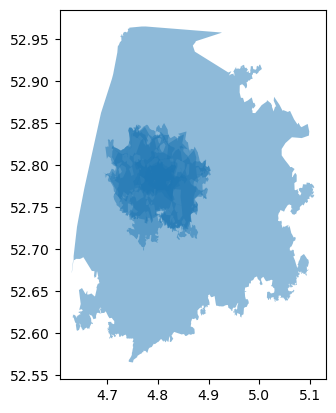

In [13]:
isochrones.plot(alpha=0.5)